# Beyin MR Görüntüleri ile Transfer Learning Kullanarak Tümör Sınıflandırma

Bu projede, beyin MR görüntülerini kullanarak tümör sınıflandırma görevini ele alıyoruz. Amacımız, önceden eğitilmiş bir VGG16 modelini kullanarak, bu görüntüler üzerinde derin öğrenme uygulayarak beyin tümörlerini sınıflandırmak. Ayrıca, veri setini daha çeşitli ve sağlam hale getirmek için veri augmentasyonu kullanılacaktır.

## Adım 1: Veri Keşfi ve Analizi
Başlangıç olarak, kullanılacak veri setini inceledik. Veri setinin yapısı, boyutları ve içeriği hakkında bilgi edindik.

## Adım 2: Veri Temizliği
Eğer veri setinde eksik veya hatalı veriler varsa, bu aşamada temizledik. Temiz veri, daha güçlü bir model eğitimine olanak sağlar.

## Adım 3: Data Augmentasyonu
Veri setini daha da zenginleştirmek için veri augmentasyonu kullandık. Görüntüler üzerinde döndürme, yansıtma, kesme, vb. işlemleri uygulayarak veri çeşitliliğini artırdık.

## Adım 4: Modelin Kurulması ve Eğitilmesi
Transfer learning kullanarak VGG16 modelini kurup eğittik. Ağırlıkları dondurma veya dondurmama seçeneklerini değerlendirdik ve modeli eğitirken kullanılacak parametreleri ayarladık.

## Adım 5: Sonuçlar ve Değerlendirme
Modelimizin performansını değerlendirdik. Sonuçlar, sınıflandırma doğruluğu, hassasiyet, özgüllük gibi metriklerle sunuldu.


## Teknolojiler ve Araçlar

- Python
- TensorFlow
- Keras
- cv2

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [21]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [22]:
X_train = []
y_train = []
image_size = 150

for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 153.44it/s]


# **Veri Analizi**

In [23]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [24]:
size_images = 150
batch_size = 64

In [25]:
train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-classification-mri/Training",                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 2870 images belonging to 4 classes.


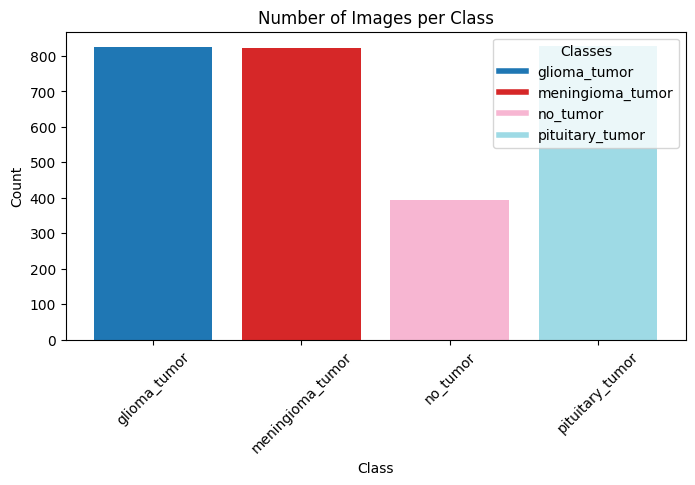

In [26]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [27]:
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [28]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/brain-tumor-classification-mri/Testing",
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 394 images belonging to 4 classes.


In [29]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

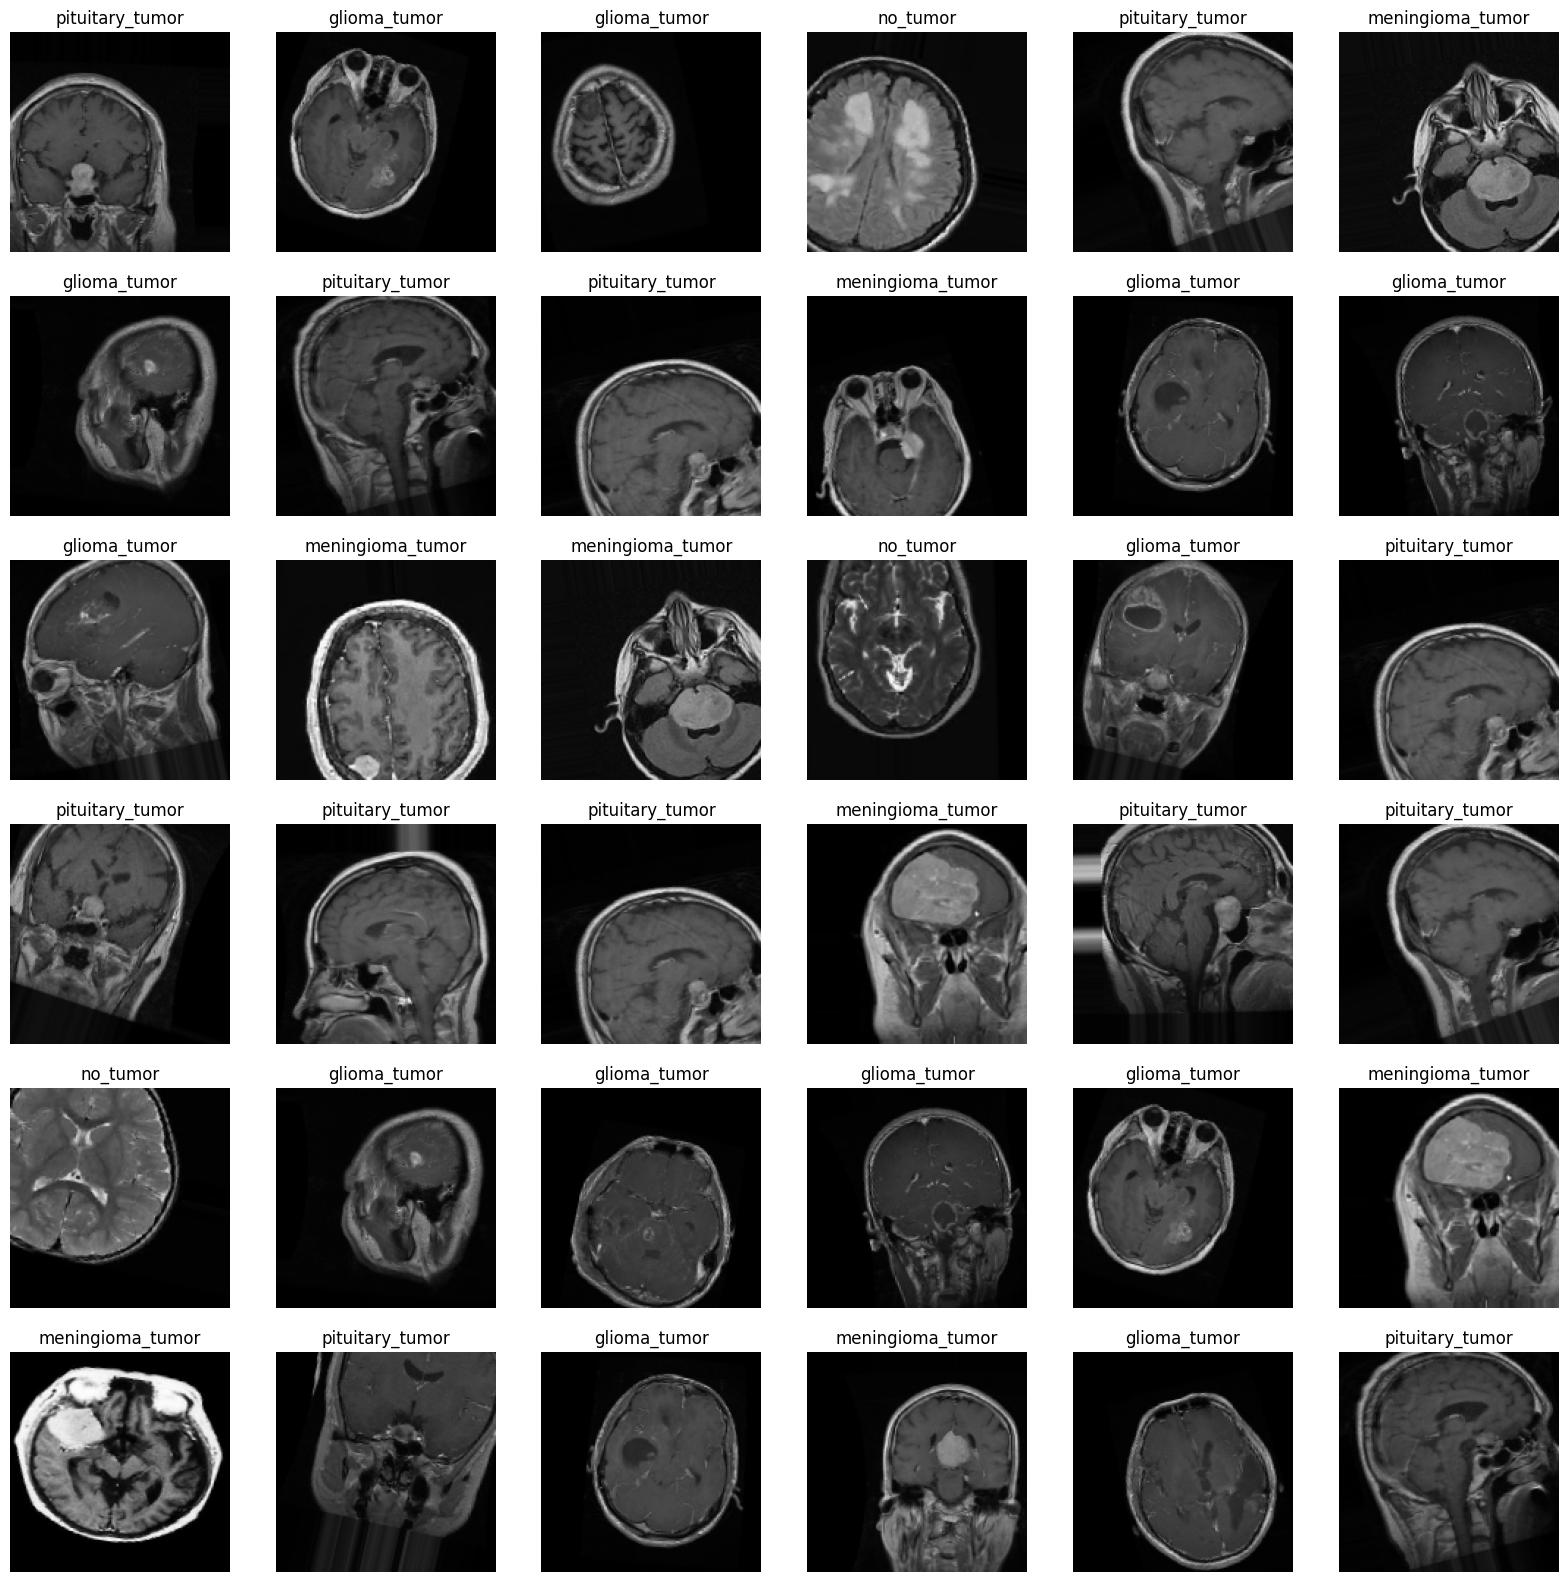

In [30]:
Show_Images(train_generator)

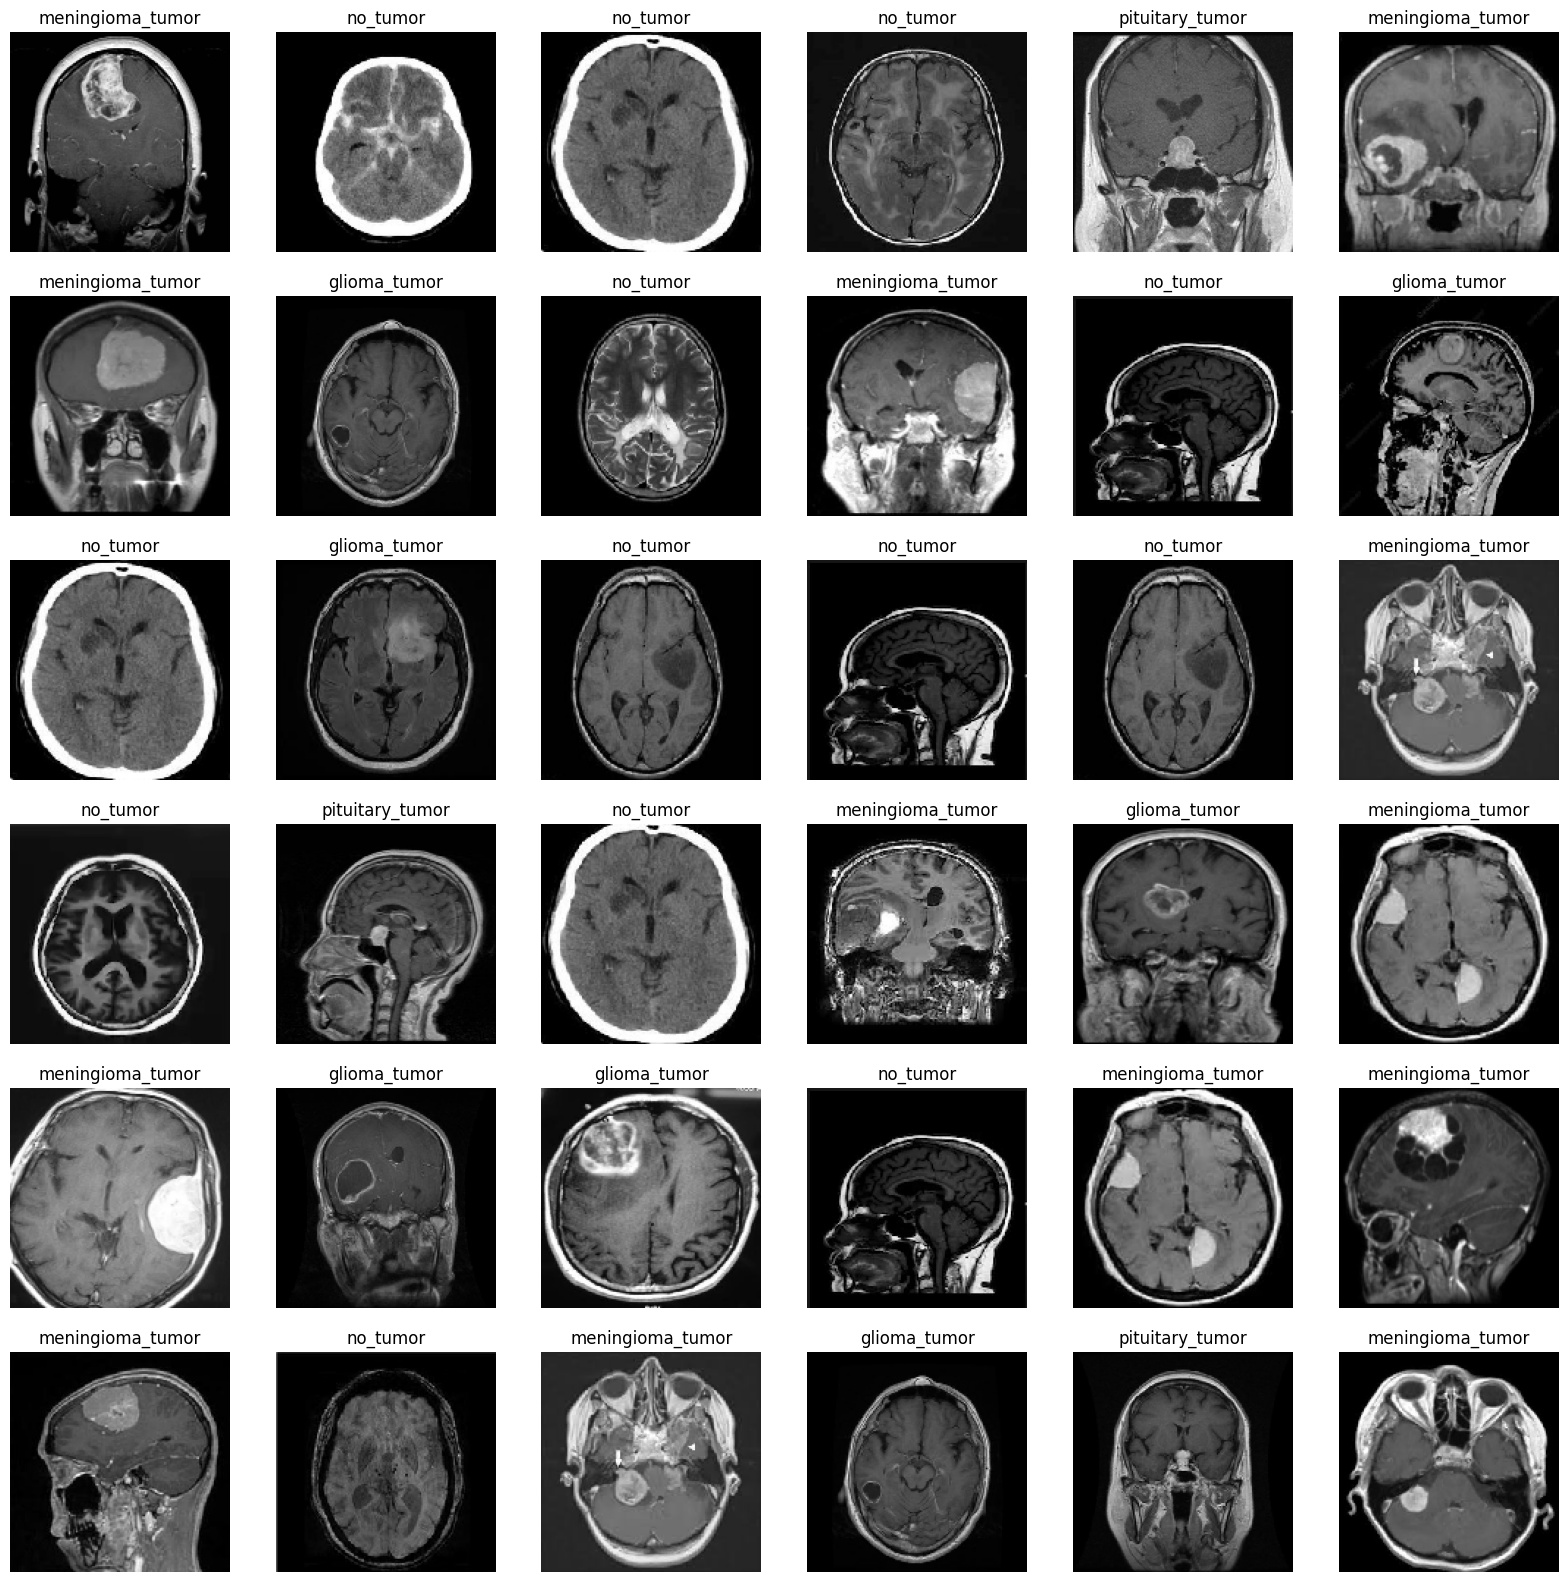

In [31]:
Show_Images(test_generator)

In [32]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [34]:
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

x_train shape (2611, 150, 150, 3)
x_test shape (653, 150, 150, 3)
y_train shape (2611,)
y_test shape (653,)


**One Hot Encoding**

In [35]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [36]:
num_classes = 4  # Sınıf sayısına göre ayarlayın

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# VGG16 modelini yükleyin
base_model = VGG16(weights='imagenet', include_top=False)

# VGG16 modelinin çıkış katmanını alın
x = base_model.output

# Global Average Pooling Layer ekleyin
x = GlobalAveragePooling2D()(x)

# Tam bağlantılı katmanları ekleyin
x = Dense(1024, activation='relu')(x)

# Çıkış katmanını ekleyin (sınıf sayısı kadar nörona sahip olmalı)
output = Dense(num_classes, activation='softmax')(x)

# Yeni modeli oluşturun
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# VGG16 modelinin dondurulmasını kaldırın (isteğe bağlı)
for layer in base_model.layers:
    layer.trainable = True

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# ModelCheckpoint geri çağırma
checkpoint = ModelCheckpoint("VGG16_model", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# ReduceLROnPlateau geri çağırma
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

# TensorBoard geri çağırma
tensorboard = TensorBoard(log_dir='logs')

# Modeli derlerken geri çağırma işlevlerini ekleyin
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitirken geri çağırma işlevlerini ekleyin
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[checkpoint, reduce_lr, tensorboard])

Epoch 1/10
82/82 [==============================] - ETA: 0s - loss: 6.1405 - accuracy: 0.2872
Epoch 1: val_accuracy improved from -inf to 0.25727, saving model to VGG16_model
82/82 [==============================] - 26s 251ms/step - loss: 6.1405 - accuracy: 0.2872 - val_loss: 1.3707 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 2/10
82/82 [==============================] - ETA: 0s - loss: 1.3615 - accuracy: 0.2903
Epoch 2: val_accuracy did not improve from 0.25727
82/82 [==============================] - 17s 206ms/step - loss: 1.3615 - accuracy: 0.2903 - val_loss: 1.3659 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 3/10
82/82 [==============================] - ETA: 0s - loss: 1.3584 - accuracy: 0.2846
Epoch 3: val_accuracy did not improve from 0.25727

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 17s 208ms/step - loss: 1.3584 - accuracy: 0.2846 - val_loss: 1.3658 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 4/10
82/82 [=====

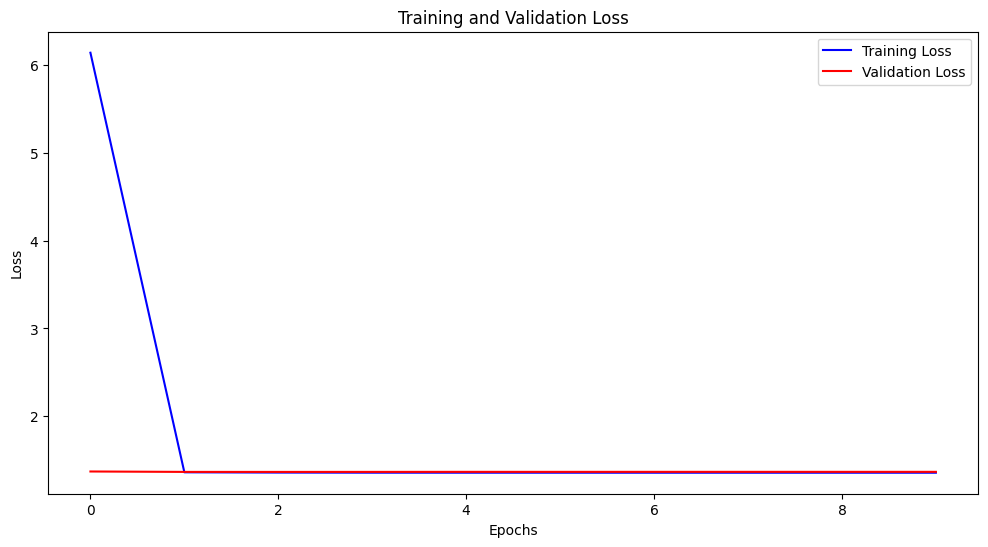

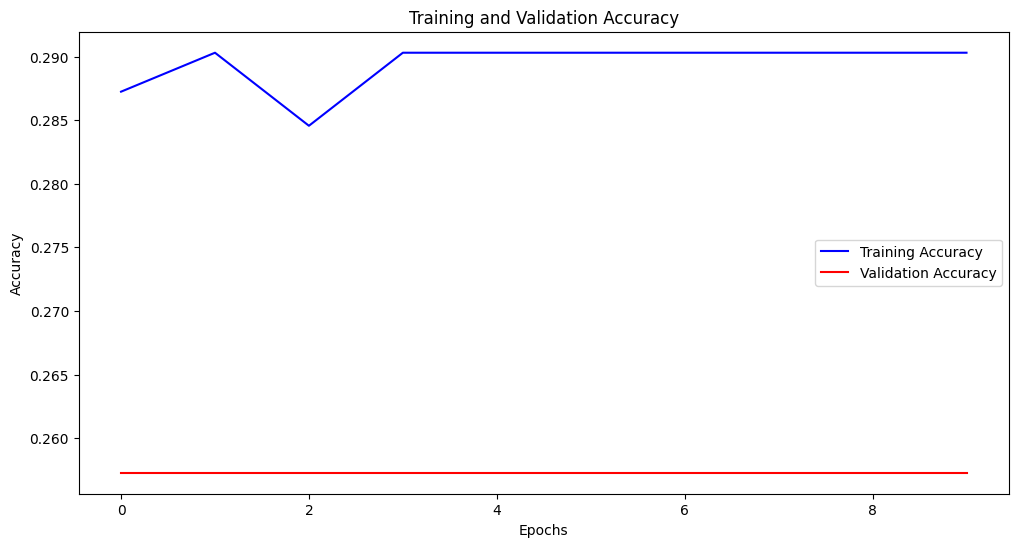

In [39]:
import matplotlib.pyplot as plt

# Eğitim işlemi sırasında kaydedilen metrikleri alın
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']

# Loss grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Gözlem**

   Data setine önce augmentasyon uyguladım bunu görselleri en başta gösterirken yaptım  sonra aşağıda uyguladım ve daha yüksek doğruluklara ulaştım burada augmentasyonun önemini görüyoruz

In [40]:
# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Veri augmentasyonu için yapılandırmaları belirleyin
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Veri augmentasyonunu uygulayın
augmented_data = []
for img in X_train:
    augmented_img = datagen.random_transform(img)
    augmented_data.append(augmented_img)

# Augmented verileri eğitim verilerine ekleyin
X_train = np.concatenate((X_train, augmented_data), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

# Modeli eğitirken veri augmentasyonunu kullanın
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[checkpoint, reduce_lr, tensorboard])

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 1.3754 - accuracy: 0.2917
Epoch 1: val_accuracy did not improve from 0.25727
164/164 [==============================] - 40s 216ms/step - loss: 1.3754 - accuracy: 0.2917 - val_loss: 1.3716 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 1.3208 - accuracy: 0.3508
Epoch 2: val_accuracy improved from 0.25727 to 0.42573, saving model to VGG16_model
164/164 [==============================] - 36s 222ms/step - loss: 1.3208 - accuracy: 0.3508 - val_loss: 1.2137 - val_accuracy: 0.4257 - lr: 0.0010
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.4200
Epoch 3: val_accuracy improved from 0.42573 to 0.43492, saving model to VGG16_model
164/164 [==============================] - 36s 219ms/step - loss: 1.2236 - accuracy: 0.4200 - val_loss: 1.0796 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 4/10
164/164 [==============================] 

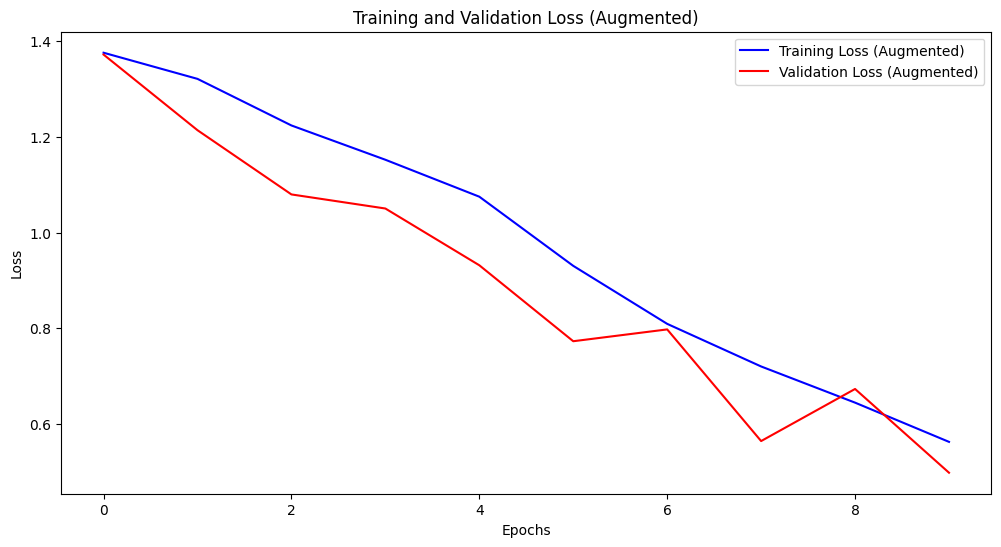

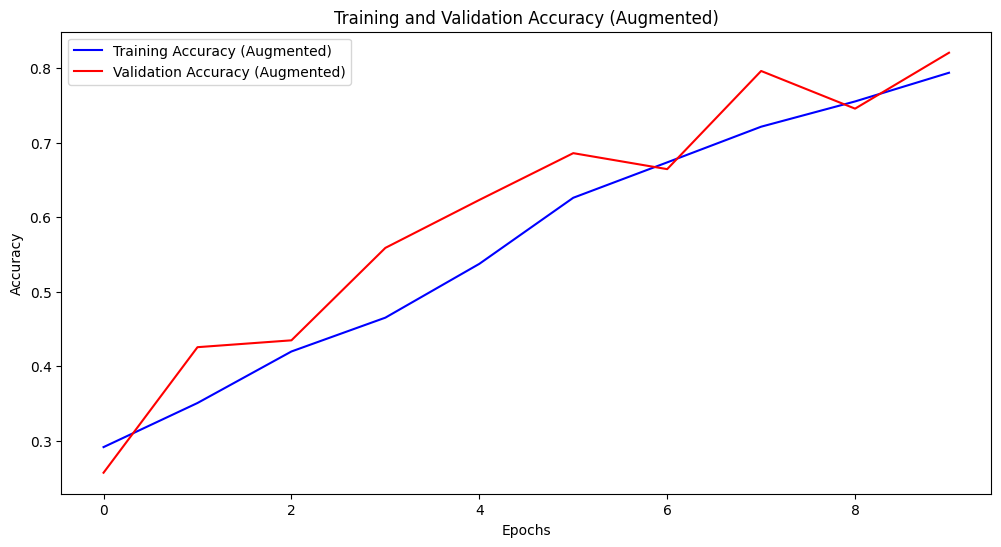

In [41]:
import matplotlib.pyplot as plt

# Eğitim işlemi sırasında kaydedilen metrikleri alın
train_loss_augmented = history2.history['loss']
val_loss_augmented = history2.history['val_loss']
train_accuracy_augmented = history2.history['accuracy']
val_accuracy_augmented = history2.history['val_accuracy']

# Loss grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_loss_augmented, label='Training Loss (Augmented)', color='blue')
plt.plot(val_loss_augmented, label='Validation Loss (Augmented)', color='red')
plt.title('Training and Validation Loss (Augmented)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy grafiği
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_augmented, label='Training Accuracy (Augmented)', color='blue')
plt.plot(val_accuracy_augmented, label='Validation Accuracy (Augmented)', color='red')
plt.title('Training and Validation Accuracy (Augmented)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

21/21 [==============================] - 1s 63ms/step


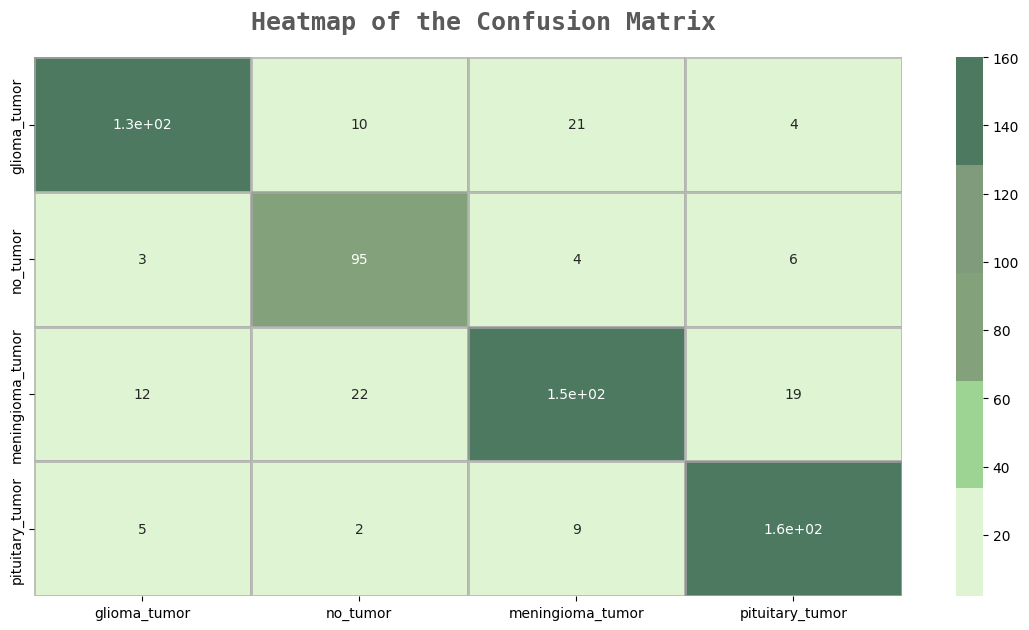

In [42]:
from sklearn.metrics import confusion_matrix

# Test verileri üzerinde tahmin yapın
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek sınıfları alın
y_true = np.argmax(y_test, axis=1)

# Confusion matrix'i oluşturun
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Heatmap'i çizin
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(conf_matrix, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

# ***Sonuç***
    Bu projede sağlık veriliri ile yapılan bir araştırmada MobileNetV3 modelinin kullanılmasının daha iyi sonuç vereceğini öğrenmiş oldum
    
    Ben VGG16 modelini kullandığımda daha düşük bir doğruluk değerine ulaşmış oldum